In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from yellowbrick.cluster import SilhouetteVisualizer

# Clustering
In this notebook we will consider the problem of clustering data. Clustering is an unsupervised learning problem with the aim to find assign each datapoint to a cluster such that the similarity between data-points within a cluster is maximized and the similarity between data-points among throughout is minimized. There are many existing clustering algorithms, we will consider two pretty simple methods, namely K-Means and Gaussian Mixture Models (GMMs). Before we can apply these algorithms to our data (which will be customer data from a shopping center), we have to perform some preprocessing. Let's directly dive into it!

## Pre-Processing
Since K-Means is based on eucledian distance, it is **very important** to ensure that (1) your data lies in $\mathbb{R}^n$ or a subspace thereof and (2) your data is normalized to ensure that the scale of variables does not affect the results of our clustering algorithm. For Gaussian Mixture Models only (1) applies, however scaling the variables does not harm. Let's load the data and see what we deal with:

In [3]:
df = pd.read_csv('../data/customer-data/segmentation data.csv')
df

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1
...,...,...,...,...,...,...,...,...
1995,100001996,1,0,47,1,123525,0,0
1996,100001997,1,1,27,1,117744,1,0
1997,100001998,0,0,31,0,86400,0,0
1998,100001999,1,1,24,1,97968,0,0


As we can see, there's an ID-column. Since the ID is independent of any other variable, let's drop it.

In [4]:
df = df.drop(columns=['ID'])
df

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,67,2,124670,1,2
1,1,1,22,1,150773,1,2
2,0,0,49,1,89210,0,0
3,0,0,45,1,171565,1,1
4,0,0,53,1,149031,1,1
...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0
1996,1,1,27,1,117744,1,0
1997,0,0,31,0,86400,0,0
1998,1,1,24,1,97968,0,0


We're lucky, all variables are real-valued already, thus to fulfill (1) there is nothing to be done. Great! However, we see that (2) is not fulfilled. For example, we have the variable *Income* and *Age* which are not on the same scale. To ensure that this won't caus any problems for K-Means, let's scale the data:

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(df)

Now that the data is scaled, we are ready to apply K-Means. The procedure is the same as for supervised tasks: Instantiate the algorithm which is already provided by sklearn, invoke fit and obtain the results. Note that we don't have any test-sets. This is because we deal with a clustering problem and our objective is not to come up with a model which is able to predict any future unseen data. Thus we don't have to ensure that our model is generalizing well, we just deal with the data we obtained and try to assign a cluster to each data-point as good as possible. 

## K-Means
K-Means performs "hard" clustering by adapting the position of so called centroids in a $n$-dimensional euclidean space. It starts by placing $k$ centroids randomly. Then for each datapoint a cluster is assigned which is done by determining the centroid with the smallest distance to the datapoint. In an optimization step, K-Means re-computes the position of each centroid by setting the position to the cluster-mean. This is done until convergence.

Using K-Means in Python is straighforward using sklearn:

In [8]:
kmeans = KMeans(5)
clusters = kmeans.fit_predict(X)

In [9]:
clusters

array([1, 0, 4, ..., 4, 2, 4], dtype=int32)

Cool, we just obtained a cluster-assignment for each data-point. But wait, what does this tell us? Hard to say for now, we don't have any ground truth which can be used to check how good our model performs. Also, setting the number of clusters (the $k$ in K-Means) is just a first educated guess. Let's try to estimate the quality of our model and use this information to come up with a high-quality model.

## Finding a good $k$
As shown in the presentation, we can use the so called "Elbow-Criterion" to obtain a good $k$. 
> Note You have to rerun your clustering algorithm from scratch for each $k$ you test. This can get very expensive if you have big datasets. 

One possible way to overcome this obstacle is to build your model on a subset of your dataset and measure the performance using this model and your subset. To ensure that you get an unbiased estimate of the performance you can repeat this multiple times, each time using a different random subset. This ensures that you don't draw biased samples from your data by accident. 

> Random sub-sampling can be useful to estiamte the performance of your clustering algorithm for different hyperparameters.

Since our dataset is small, we won't perform random sub-sampling. So let's see how the Elbow-Criterion works and what it tells us about the choice of $k$:

In [18]:
ks = list(range(3, 100))
distortions = []
for k in ks:
    kmeans = KMeans(k)
    clusters = kmeans.fit_predict(X)
    distortion = np.sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
    distortions.append(distortion)

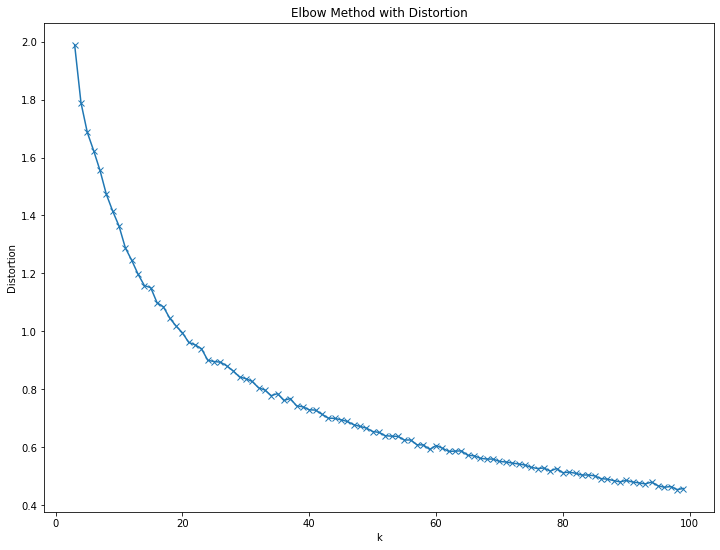

In [19]:
fig = plt.figure(figsize=(12, 9))
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method with Distortion')
plt.plot(ks, distortions, marker='x')
plt.show()

It can be seen that K-Means has problems finding good clusters because the distortion decreases only slightly with rising $k$ and the curve does not show the typical "Elbow"-shape.
Nevertheless, we find that 20-25 seems to be a good choice for $k$ since $k > 25$ does not yield very much benefit with respect to the distortion-value we used to assess the quality of the results returned by K-Means. Let's fit a K-Means model for $k = 20$ and obtain its silhouette score:

In [32]:
kmeans = KMeans(20)
clusters = kmeans.fit_predict(X)

In [21]:
sil_score = silhouette_score(X, kmeans.labels_, metric='euclidean')
sil_score

0.3705408741491687

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=20))

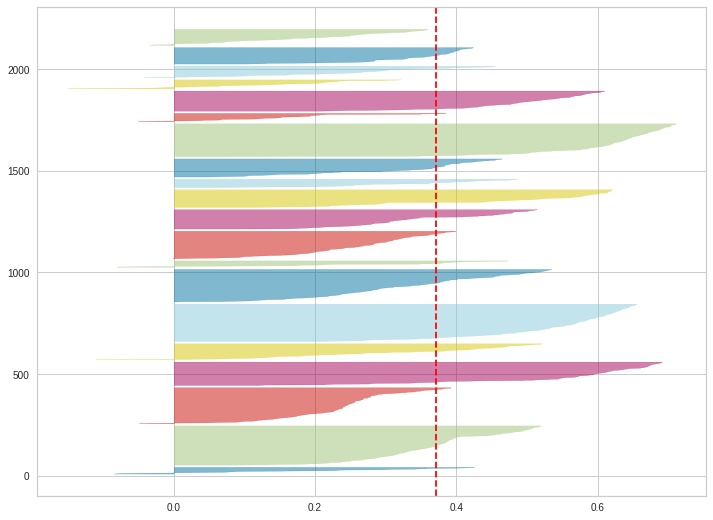

In [25]:
fig = plt.figure(figsize=(12, 9))
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)

Nice plot! But how do we interpret it? This plot shows the silhouette-coefficient computed for each point in our dataset. Each point is assigned to a cluster (indicated by the colors) and achieves a certain silhouette-score (the length of the bar). The dotted red line is the average silhouette score over all datapoints. We see that most clusters contain points achieving a higher silhouette-score larger than the average which is a good sign. Some cluster do not, so it might be that we missed the optimal $k$. However: There are very few points receiving a negative silhouette score, i.e. there are almost no points which lie nearer to a cluster they are not assigned to. Overall we can say that the performance of K-Means on our dataset is not optimal, but still sufficient.

## Gaussian Mixture Models (GMMs)
In contrast to K-Means GMMs perform "soft" clustering. This means, instead of assigning *one* cluster to each datapoint, we compute a probability that some datapoint $\mathbf{x}_i$ is assigned to a cluster $c$. This is done with a similar procedure (Expectation Maximization) as K-Means computes centroids. The basic idea is to initilaize $k$ different Gaussian-distributions, each having a mean vector $\mu_i$ and covariance matrix $\Sigma_i$. Then the EM-algorithm assigns a cluster to each data-point, however, this time each cluster receives a probability of being part of cluster $c$. In the maximazation step we adapt the mean and covariance matrix s.t. we maximize the probability of obtaining the data given our estimates of $\mu_1, \dots, \mu_k$ and $\Sigma_1, \dots, \Sigma_k$. 

Let's see how we can apply GMMs to our data:

In [27]:
gmm = GaussianMixture(5)
clusters = gmm.fit_predict(X)

Esay, hm? The Elbow-method will tell us which $k$ we should use, just as for K-Means:

In [30]:
ks = list(range(3, 100))
distortions = []
for k in ks:
    gmm = GaussianMixture(k)
    clusters = gmm.fit_predict(X)
    distortion = np.sum(np.min(cdist(X, gmm.means_, 'euclidean'), axis=1)) / X.shape[0]
    distortions.append(distortion)

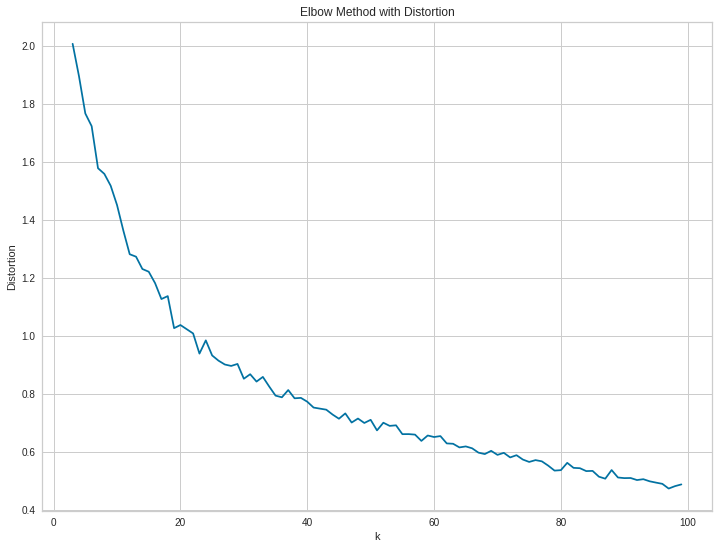

In [31]:
fig = plt.figure(figsize=(12, 9))
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method with Distortion')
plt.plot(ks, distortions, marker='x')
plt.show()

Not surprisingly, we see a similar Elbow-curve for GMMs as for K-Means. Let's say 20 is a good estiamte for $k$ in this case. As above, let's see the silhouette scores:

In [37]:
gmm = GaussianMixture(20)
clusters = gmm.fit_predict(X)
sil_score = silhouette_score(X, clusters, metric='euclidean')
sil_score

0.34196593931346886

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=20))

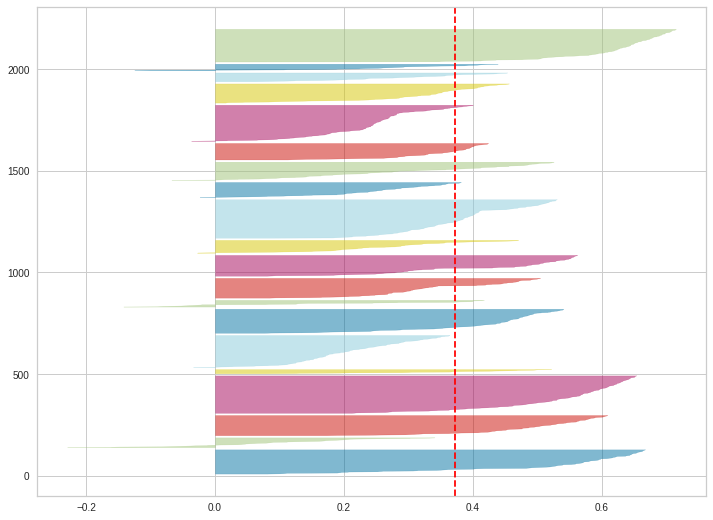

In [38]:
fig = plt.figure(figsize=(12, 9))
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)

We see a similar result as for K-Means: Most of the clusters contain points with a good silhouette score, some are below the average and a few receive a negative value. Nevertheless, on average, K-Means performed better than GMM. However, note that we did not perform an exhaustive hyperparameter optimization in this case.

> **Task**
> 
> Think about different possibilities to measure how good a cluster-model is, other than silhouette scores.
> 
> **Note:** There are no labels of the data we can compare our results to!